# Image classification with small data

1. Download and setup dataset (Kaggle Cats & Dogs) https://www.kaggle.com/c/dogs-vs-cats/data
2. Train a small convnet on our small data (acc ~ 0.75)
3. Train a MLP using bottleneck features of pretrained model (acc ~ 0.90)
4. Finetuning top layers of pretrained model on our small data (acc ~ 0.94)

<b>Complete tutorial</b>: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [28]:
# imports
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import applications
import numpy as np
from keras import Model
from keras import optimizers
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
# define plot & parse functions
def parse_log_file(pfile):
    f= open(pfile).readlines()
    lines = [i.strip() for i in f]
    log= {k:[] for k in ['acc','val_acc','loss','val_loss']}
    for l in lines:
        if 'loss' in l:
            for k in log.keys():
                log[k].append(float(l.split(k+': ')[1].split(' -')[0]))
    return log 

def plot_loss_acc(pfile):
    history = parse_log_file(pfile)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [86]:
img_width, img_height = 150, 150
input_shape = (img_width, img_height, 3)

## Train a small convnet on our small data

In [3]:
# define small conv net: 3 conv blocks (conv,activation,pooling) + 2 dense layers
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# compile model with binary crossentropy loss and rmsprop optimizer
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

In [6]:
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [7]:
# training data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
# testing data augmentation (only rescaling)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [87]:
# training data generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')
# validation data generator
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [11]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('ConvNet_from_scratch.h5')
# ~ 12:40 start - end 14:19:44 (around 1:40 on cpu) 

Epoch 1/50
125/125 [==============================] - 146s 1s/step - loss: 0.7626 - acc: 0.5145 - val_loss: 0.6708 - val_acc: 0.5725
Epoch 2/50
125/125 [==============================] - 157s 1s/step - loss: 0.6781 - acc: 0.6060 - val_loss: 0.6623 - val_acc: 0.5513
Epoch 3/50
125/125 [==============================] - 130s 1s/step - loss: 0.6326 - acc: 0.6515 - val_loss: 0.5866 - val_acc: 0.6950
Epoch 4/50
125/125 [==============================] - 131s 1s/step - loss: 0.6047 - acc: 0.6795 - val_loss: 0.5987 - val_acc: 0.6475
Epoch 5/50
125/125 [==============================] - 120s 958ms/step - loss: 0.6089 - acc: 0.6990 - val_loss: 0.5760 - val_acc: 0.6837
Epoch 6/50
125/125 [==============================] - 118s 946ms/step - loss: 0.5749 - acc: 0.7050 - val_loss: 0.5441 - val_acc: 0.7163
Epoch 7/50
125/125 [==============================] - 113s 905ms/step - loss: 0.5416 - acc: 0.7185 - val_loss: 0.5316 - val_acc: 0.7338
Epoch 8/50
125/125 [==============================] - 107s 8

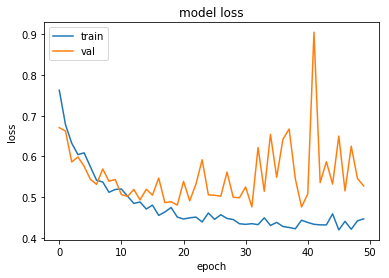

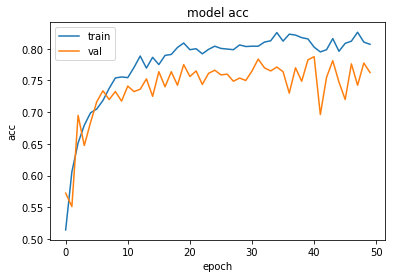

In [98]:
plot_loss_acc('ConvNet_from_scratch_log')

## Train a MLP using bottleneck features

In [19]:
# 1. extract features from pretrained VGG model on imagenet (can be any other)

# normalize pixel values
datagen = ImageDataGenerator(rescale=1. / 255) 

# build the VGG16 network, don't include the fully-connected layer at the top of the network and use imagenet weights
vgg_model = applications.VGG16(include_top=False, weights='imagenet') 

generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None, # we don't need labels
    shuffle=False) # forward-pass, no need for shuffling
bottleneck_features_train = vgg_model.predict_generator(generator, nb_train_samples // batch_size)
np.save(open('bottleneck_features_train.npy', 'w'), bottleneck_features_train)

generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)
bottleneck_features_validation = vgg_model.predict_generator(generator, nb_validation_samples // batch_size)
np.save(open('bottleneck_features_validation.npy', 'w'),bottleneck_features_validation)

In [23]:
# 2. Train a MLP using bottleneck features of pretrained model

train_data = np.load(open('bottleneck_features_train.npy'))
train_labels = np.array([0] * (nb_train_samples / 2) + [1] * (nb_train_samples / 2))

validation_data = np.load(open('bottleneck_features_validation.npy'))
validation_labels = np.array([0] * (nb_validation_samples / 2) + [1] * (nb_validation_samples / 2))

# define model of two dense layers 
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))

top_model_weights_path = 'bottleneck_fc_model.h5' 
model.save_weights(top_model_weights_path)

Train on 2000 samples, validate on 800 samples
Epoch 1/50
2000/2000 [==============================] - 6s 3ms/step - loss: 0.7413 - acc: 0.7690 - val_loss: 0.2978 - val_acc: 0.8712
Epoch 2/50
2000/2000 [==============================] - 5s 3ms/step - loss: 0.3311 - acc: 0.8620 - val_loss: 0.2544 - val_acc: 0.9012
Epoch 3/50
2000/2000 [==============================] - 5s 2ms/step - loss: 0.2754 - acc: 0.8920 - val_loss: 0.2510 - val_acc: 0.9038
Epoch 4/50
2000/2000 [==============================] - 5s 3ms/step - loss: 0.2454 - acc: 0.8895 - val_loss: 0.2472 - val_acc: 0.9050
Epoch 5/50
2000/2000 [==============================] - 5s 3ms/step - loss: 0.2122 - acc: 0.9160 - val_loss: 0.2717 - val_acc: 0.8912
Epoch 6/50
2000/2000 [==============================] - 5s 3ms/step - loss: 0.1793 - acc: 0.9255 - val_loss: 0.2681 - val_acc: 0.9087
Epoch 7/50
2000/2000 [==============================] - 5s 3ms/step - loss: 0.1606 - acc: 0.9310 - val_loss: 0.3846 - val_acc: 0.8762
Epoch 8/50
2000

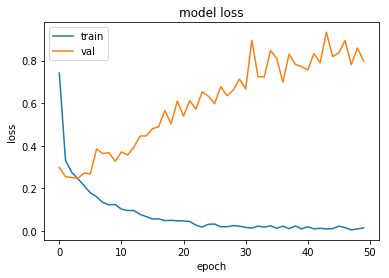

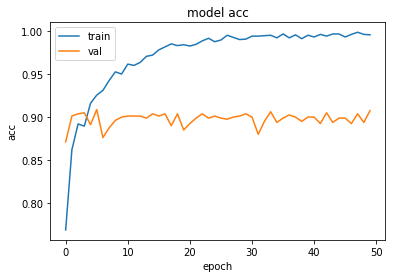

In [99]:
plot_loss_acc('bottleneck_fc_model_log')

## Finetuning top layers of pretrained model on our small data

In [27]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150,3))
print('Base model loaded.')

Model loaded.


In [29]:
top_model_weights_path = 'bottleneck_fc_model.h5' 
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

In [36]:
#add the model on top of the convolutional base
new_model = Model(input=base_model.input, output=top_model(base_model.output))

/Users/nour/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in new_model.layers[:15]:
    layer.trainable = False

In [40]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
new_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [ ]:
# fine-tune the model
new_model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    epochs=epochs,
    validation_data=validation_generator,
    nb_val_samples=nb_validation_samples)

new_model.save_weights('finetuned_vgg.h5')
# duration ~ 5 hours on gpu

/Users/nour/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/Users/nour/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=125, epochs=50, validation_steps=800)`
  import sys


Epoch 1/50
125/125 [==============================] - 7179s 57s/step - loss: 0.4159 - acc: 0.9335 - val_loss: 0.7976 - val_acc: 0.9075
Epoch 2/50
125/125 [==============================] - 7133s 57s/step - loss: 0.3714 - acc: 0.9400 - val_loss: 0.7976 - val_acc: 0.9075
Epoch 3/50
125/125 [==============================] - 7073s 57s/step - loss: 0.4257 - acc: 0.9425 - val_loss: 0.7976 - val_acc: 0.9075
Epoch 4/50
125/125 [==============================] - 7074s 57s/step - loss: 0.4196 - acc: 0.9375 - val_loss: 0.7976 - val_acc: 0.9075
Epoch 5/50
124/125 [============================>.] - ETA: 7s - loss: 0.4411 - acc: 0.9355 

KeyboardInterrupt: 

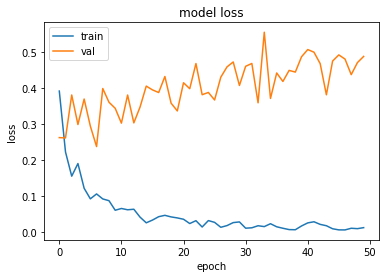

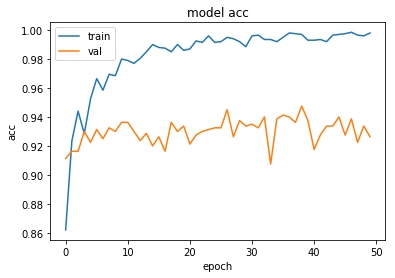

In [97]:
plot_loss_acc('finetuning_vgg_log')

In [26]:
import numpy as np
train_data = np.load(open('bottleneck_features_train.npy'))

In [27]:
train_data.shape

(2000, 4, 4, 512)